In [105]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import pandas as pd

def rmMissing(df: pd.DataFrame, header: list):
    idx = []
    for i in range(1,len(df.columns)):
        if ((df[df.columns[i]].dtypes == "float64") or (df.columns[i]=="traffic_load_man") or (df.columns[i]=="traffic_int_road")):
            if not (df.columns[i]=="bread_intake" or df.columns[i]=="tea_intake" or df.columns[i]=="veggie_intake" or df.columns[i]=="time_tv"):
                if len(df.loc[df[df.columns[i]]==0]):
                    idx.append(i)
    for col in df[df.columns[idx]].columns:
        del df[col]
        headers.remove(col)
def rmNBehavior(df: pd.DataFrame, header: list):
    for name in header:
        if name in df.columns:
            del df[name]

df = pd.read_csv("dat.csv")
del df["chip"]
headers = ["cad", "alcohol_intake", "fish_oil_intake", "close_to_road", "chest_pain", "high_bp", "high_chol", "diabetes", "location", "bmi", "age", "gender", "pca1", "pca2", "pca3", "walking_freq", "time_tv", "time_sleep", "var_sleep", "townsend", "veggie_intake", "bread_intake", "tea_intake", "dia_pressure", "sys_pressure", "pulse", "num_veh", "inv_maj_road_dist", "inv_road_dist", "no2_2005", "no2_2006", "no2_2007", "no2_2010", "no_2010", "pm10_2007", "len_maj_road", "traffic_load_man","traffic_int_maj", "traffic_int_road","day_noise", "night_noise"]
df.columns = headers
rmMissing(df, headers)
#nBehavior = ["close_to_road", "chest_pain", "high_bp", "high_chol", "diabetes", "location", "bmi", "age", "gender", "pca1", "pca2", "pca3","dia_pressure", "townsend", "sys_pressure", "pulse","inv_maj_road_dist", "inv_road_dist", "no2_2005", "no2_2006", "no2_2007", "no2_2010", "no_2010", "pm10_2007", "len_maj_road", "traffic_load_man","traffic_int_maj", "traffic_int_road","day_noise", "night_noise"]
#rmNBehavior(df, nBehavior)
print(df.columns)

x = df.iloc[:,1:]

Index(['cad', 'alcohol_intake', 'fish_oil_intake', 'close_to_road',
       'chest_pain', 'high_bp', 'high_chol', 'diabetes', 'location', 'bmi',
       'age', 'gender', 'pca1', 'pca2', 'pca3', 'walking_freq', 'time_tv',
       'time_sleep', 'var_sleep', 'townsend', 'veggie_intake', 'bread_intake',
       'tea_intake', 'dia_pressure', 'sys_pressure', 'pulse', 'num_veh',
       'inv_maj_road_dist', 'inv_road_dist', 'no2_2005', 'no2_2006',
       'no2_2007', 'no2_2010', 'no_2010', 'pm10_2007', 'traffic_int_maj',
       'traffic_int_road', 'day_noise', 'night_noise'],
      dtype='object')


In [122]:
"""Full tree with pruning"""
mode = "Entropy"
name_modifier = ", Balanced"#", Full Set of Covariates" #
bal = "balanced" # None
X_train, X_test, Y_train, Y_test = train_test_split(x, df.iloc[:,0], random_state=2)
entropy_tree = DecisionTreeClassifier(criterion=mode.lower(), class_weight=bal)
et_path = entropy_tree.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = et_path.ccp_alphas, et_path.impurities
entropy_tree.fit(X_train, Y_train)

fig, ax = plt.subplots(3,1, figsize=(7,8))
ax[0].plot(ccp_alphas[:], impurities[:], marker='o', drawstyle="steps-post", markerfacecolor="r", color="k")
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel("Total Impurity of Leaves")
ax[0].set_title("Total Impurity vs "+ r'$\alpha$' +", " + mode + name_modifier)

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, criterion=mode.lower(), class_weight=bal)
    clf.fit(X_train, Y_train)
    clfs.append(clf)
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post", markerfacecolor="r",color="k")
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel("Depth of Tree")
ax[1].set_title("Depth vs " + r'$\alpha$' + ", " + mode + name_modifier)

train_scores = [clf.score(X_train, Y_train) for clf in clfs]
test_scores = [clf.score(X_test, Y_test) for clf in clfs]

ax[2].set_xlabel(r'$\alpha$')
ax[2].set_ylabel("Accuracy")
ax[2].set_title("Accuracy vs " + r'$\alpha$' +", " + mode + name_modifier)
ax[2].plot(ccp_alphas, train_scores, marker='o', label="Train",
        drawstyle="steps-post")
ax[2].plot(ccp_alphas, test_scores, marker='o', label="Test",
        drawstyle="steps-post")
ax[2].legend()
fig.tight_layout()
plt.show()

SyntaxError: invalid syntax (<ipython-input-122-43bfef05f49e>, line 3)

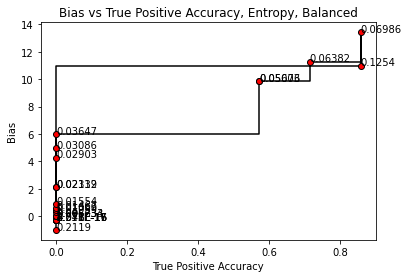

In [119]:
cm = []
weighted_bias = []
true_pos_corr = []
fig, ax = plt.subplots()

for i in range(len(ccp_alphas)):
    cm.append(confusion_matrix(clfs[i].predict(X_test), Y_test))
    weighted_bias.append(((cm[i][1][0] + cm[i][1][1]) - (cm[i][0][1] + cm[i][1][1]))/((cm[i][0][1] + cm[i][1][1])))
    true_pos_corr.append(cm[i][1][1] / (cm[i][0][1] + cm[i][1][1]))
    plt.text(true_pos_corr[i],weighted_bias[i], "%.4G" % ccp_alphas[i])


ax.plot(true_pos_corr,weighted_bias,  marker='o', drawstyle="steps-post", markerfacecolor="r",color="k")
ax.set_xlabel('True Positive Accuracy')
ax.set_ylabel("Bias")
ax.set_title("Bias vs True Positive Accuracy, " + mode + name_modifier)
plt.show()


Text(0.5, 1.0, 'Confusion Matrix, Entropy, $\\alpha$=0.21189960882608738')

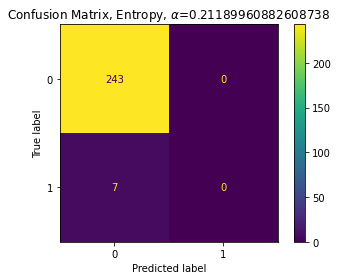

In [123]:
disp = plot_confusion_matrix(clfs[-1],X_test, Y_test)
disp.ax_.set_title("Confusion Matrix, "+mode+", " + r'$\alpha$' + '=' + str(ccp_alphas[-1]))

In [113]:
from pydotplus.graphviz import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(                           # Create dot data
    entropy_tree, filled=True, rounded=True,
    class_names=['nCAD','CAD'],
    feature_names=df.columns[1:],
    out_file=None
)

graph = graph_from_dot_data(dot_data) 
graph.write_png('full_gini_tree.png')                           # Write graph to PNG image

True

1


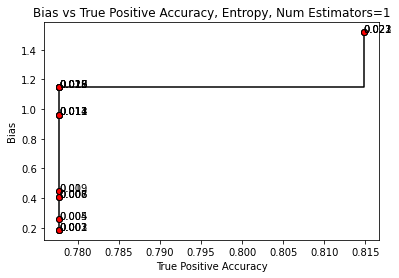

10


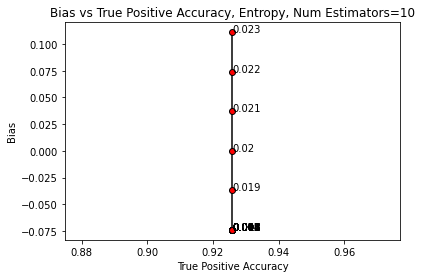

20


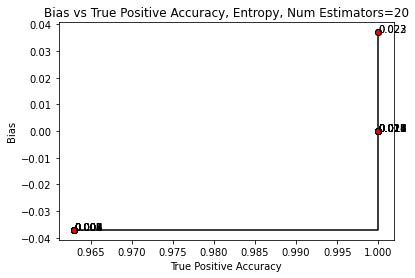

30


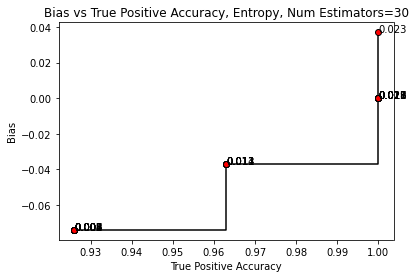

40


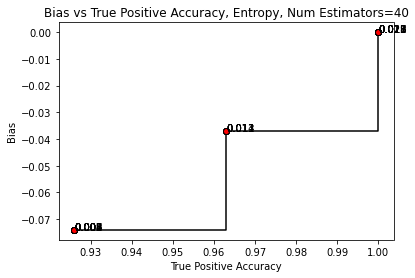

50


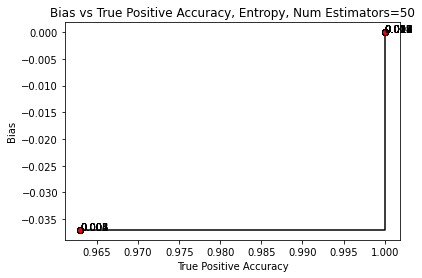

In [118]:
l = [k/1000 for k in range(0,24, 1)]
for i in [1,10,20,30,40,50]:
    bcm = []
    bweighted_bias = []
    btrue_pos_corr = []
    fig, ax = plt.subplots()
    print(i)
    for j in l:
        bt = DecisionTreeClassifier(random_state=0, max_features=None, ccp_alpha=j, criterion=mode.lower(), class_weight=bal)
        bag = BaggingClassifier(base_estimator=bt, n_estimators=i, max_samples=1.0, random_state=0)
        bag = bag.fit(x, df.iloc[:,0])
        bcm = confusion_matrix(bag.predict(x),  df.iloc[:,0] )
        bweighted_bias.append(((bcm[1][0] + bcm[1][1]) - (bcm[0][1] + bcm[1][1]))/((bcm[0][1] + bcm[1][1])))
        btrue_pos_corr.append(bcm[1][1] / (bcm[0][1] + bcm[1][1]))

    ax.plot(btrue_pos_corr,bweighted_bias,  marker='o', drawstyle="steps-post", markerfacecolor="r",color="k")
    ax.set_xlabel('True Positive Accuracy')
    ax.set_ylabel("Bias")
    ax.set_title("Bias vs True Positive Accuracy, " + mode + ', Num Estimators=' + str(i))
    ind = 0
    for el in l:
        plt.text(btrue_pos_corr[ind],bweighted_bias[ind], str(el))
        ind += 1
    plt.show()

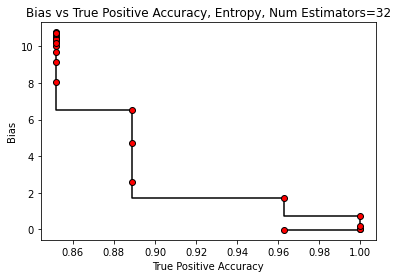

In [77]:
fig, ax = plt.subplots()
ax.plot(btrue_pos_corr,bweighted_bias,  marker='o', drawstyle="steps-post", markerfacecolor="r",color="k")
ax.set_xlabel('True Positive Accuracy')
ax.set_ylabel("Bias")
ax.set_title("Bias vs True Positive Accuracy, " + mode + ', Num Estimators=' + str(i))
plt.show()

In [ ]:
l = [k/100 for k in range(0,24, 1)]

for el in l:
    print(type(el))

In [104]:
print(len(df.columns))



39
